# Reuters 뉴스 기사 토픽 분류 (다중 분류)

데이터 로드 및 필요한 라이브러리 import

In [ ]:
from keras.datasets import reuters
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# train, test 데이터로 나눔 (단어: 10000개)
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 0s 0us/step


데이터셋 shape 확인

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(8982,)
(8982,)
(2246,)


train 데이터 확인

In [ ]:
train_data[0][:10]

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207]

train 라벨 확인 (토픽 인덱스: 0~45)

In [ ]:
train_labels[0]

3

Decoding (단어 -> 텍스트)

In [ ]:
word_index = reuters.get_word_index()    # word_index: 단어를 정수 인덱스에 매핑하는 사전
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])    # 정수 인덱스를 단어로 매핑하여 뒤집음
decoded_news = ' '.join(    # 뉴스를 Decode함. 0, 1, 2는 "패딩", "시퀀스 시작"및 "알 수 없음"에 대한 index이므로 index는 3으로 offset됨
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


벡터화 (데이터를 벡터로 변환)

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))   # zero 행렬 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.    # 해당 뉴스 기사에 들어있는 단어의 index를 1.0으로 변경
    return results

In [ ]:
x_train = vectorize_sequences(train_data)    # training data 벡터화
x_test = vectorize_sequences(test_data)      # test data 벡터화

display(x_train.shape)
display(x_test.shape)

(8982, 10000)

(2246, 10000)

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

One-hot encoding

In [ ]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

display(one_hot_train_labels.shape)
display(one_hot_test_labels.shape)

(8982, 46)

(2246, 46)

In [ ]:
one_hot_train_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

모델 생성

In [ ]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))    # relu 사용
model.add(layers.Dropout(0.3))    # dropout을 0.3만큼 적용
model.add(layers.Dense(64, activation='relu'))    # relu 사용
model.add(layers.Dropout(0.3))    # dropout을 0.3만큼 적용
model.add(layers.Dense(64, activation='relu'))    # relu 사용
model.add(layers.Dropout(0.3))    # dropout을 0.3만큼 적용
model.add(layers.Dense(46, activation='softmax'))    # 46개의 토픽 분류이기 때문에 출력이 46인 softmax 사용

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 46)               

테스트, 검증 데이터 분리

In [ ]:
x_val = x_train[:1000]    # 검증 데이터를 1000개로 설정
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]    # 검증 데이터를 1000개로 설정
partial_y_train = one_hot_train_labels[1000:]

모델 컴파일

In [ ]:
model.compile(
    optimizer='adam',    # adam optimizer 사용
    loss='categorical_crossentropy',    # 다중 분류이기 때문에 categorical_crossentropy 사용
    metrics=['acc'])

모델 학습

In [ ]:
history = model.fit(
    partial_x_train, 
    partial_y_train,
    epochs=10,    # 10개의 에폭만큼 수행
    batch_size=512,    # batch_size를 512로 설정
    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 1s 81us/step - loss: 3.4312 - acc: 0.2600 - val_loss: 2.5486 - val_acc: 0.5330
Epoch 2/10
7982/7982 [==============================] - 0s 53us/step - loss: 2.2509 - acc: 0.5163 - val_loss: 1.6744 - val_acc: 0.5930
Epoch 3/10
7982/7982 [==============================] - 0s 53us/step - loss: 1.6896 - acc: 0.6019 - val_loss: 1.4506 - val_acc: 0.6760
Epoch 4/10
7982/7982 [==============================] - 0s 54us/step - loss: 1.4264 - acc: 0.6601 - val_loss: 1.3007 - val_acc: 0.6990
Epoch 5/10
7982/7982 [==============================] - 0s 54us/step - loss: 1.2377 - acc: 0.7115 - val_loss: 1.1942 - val_acc: 0.7270
Epoch 6/10
7982/7982 [==============================] - 0s 53us/step - loss: 1.1006 - acc: 0.7400 - val_loss: 1.1194 - val_acc: 0.7540
Epoch 7/10
7982/7982 [==============================] - 0s 52us/step - loss: 0.9668 - acc: 0.7643 - val_loss: 1.0730 - val_acc: 0.7730
Epoch 8

모델 평가

In [ ]:
model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 110us/step


[1.1515329279012163, 0.7591273188591003]

훈련 결과 시각화

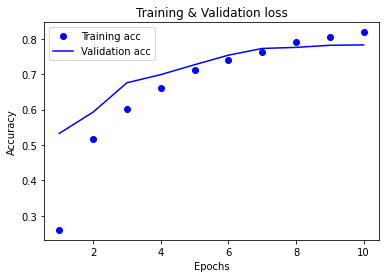

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

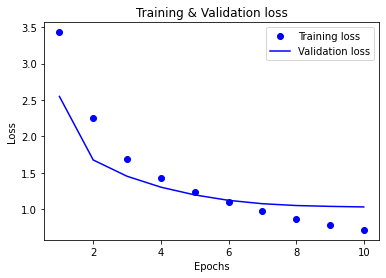

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

새로운 데이터 예측

In [ ]:
predictions = model.predict(x_test)
predictions.shape

(2246, 46)

In [ ]:
# predictions[7]의 몇 번째 index가 가장 큰 값
# (46개의 뉴스 토픽 중 그 토픽에 해당하는 확률)을 가지는지
np.argmax(predictions[7])

3

In [ ]:
# 가장 큰 값을 가진 3번째 index의 확률 출력
predictions[7][3]

0.99945027